Author: **Ermishin Andrei**

## Predict the winner in Dota2

In [57]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

### 1) Load data

In [58]:
features = pd.read_csv('./features.csv', index_col=0)
print(features.shape)
features.head()

(97230, 108)


,start_time,lobby_type,r1_hero,r1_level,r1_xp,r1_gold,r1_lh,r1_kills,r1_deaths,r1_items,...,dire_boots_count,dire_ward_observer_count,dire_ward_sentry_count,dire_first_ward_time,duration,radiant_win,tower_status_radiant,tower_status_dire,barracks_status_radiant,barracks_status_dire
match_id,,,,,,,,,,,,,,,,,,,,,
0,1430198770,7,11,5,2098,1489,20,0,0,7,...,4,2,2,-52.0,2874,1,1796,0,51,0
1,1430220345,0,42,4,1188,1033,9,0,1,12,...,4,3,1,-5.0,2463,1,1974,0,63,1
2,1430227081,7,33,4,1319,1270,22,0,0,12,...,4,3,1,13.0,2130,0,0,1830,0,63
3,1430263531,1,29,4,1779,1056,14,0,0,5,...,4,2,0,27.0,1459,0,1920,2047,50,63
4,1430282290,7,13,4,1431,1090,8,1,0,8,...,3,3,0,-16.0,2449,0,4,1974,3,63


In [59]:
# Delete features related to match results.
features.drop(['duration',
               'tower_status_radiant', 'tower_status_dire',
               'barracks_status_radiant', 'barracks_status_dire'],
              axis='columns', inplace=True)

features.drop('start_time', axis='columns', inplace=True)
features.shape

(97230, 102)

### 2) Replace missing data

In [60]:
# Missed values only in '..._time' and 'first_blood_...' columns.
cols_with_na = features.isnull().sum()
print('Total missing values:', cols_with_na.sum(),
      f', {100 * cols_with_na.sum() / features.size:.2f}% of all data.')
cols_with_na[cols_with_na > 0]

Total missing values: 193087 , 1.95% of all data.


first_blood_time               19553
first_blood_team               19553
first_blood_player1            19553
first_blood_player2            43987
radiant_bottle_time            15691
radiant_courier_time             692
radiant_flying_courier_time    27479
radiant_first_ward_time         1836
dire_bottle_time               16143
dire_courier_time                676
dire_flying_courier_time       26098
dire_first_ward_time            1826
dtype: int64

As we can see if a team didn't buy `bottle` item the value in column `_bottle_time` will be empty.

If there was no `first_blood_` event in first 5 minutes then the values in these columns will be empty.

In [61]:
# features.fillna(features.mean(), inplace=True)
features.fillna(0, inplace=True)

### 3) Training - Gradient Boosting

In [62]:
X = features.drop('radiant_win', axis='columns')
y = features['radiant_win']

In [63]:
from sklearn.model_selection import KFold, cross_val_score
from sklearn.ensemble import GradientBoostingClassifier
import datetime

Number of trees: 10 	Score: 0.6643877206345741 	Time elapsed: 0:00:14.059855
Number of trees: 20 	Score: 0.6828535735340823 	Time elapsed: 0:00:26.333607
Number of trees: 30 	Score: 0.6894962060591201 	Time elapsed: 0:00:35.554455
Number of trees: 40 	Score: 0.6941395886398829 	Time elapsed: 0:00:46.925189
Number of trees: 50 	Score: 0.6974815295110693 	Time elapsed: 0:00:57.707189


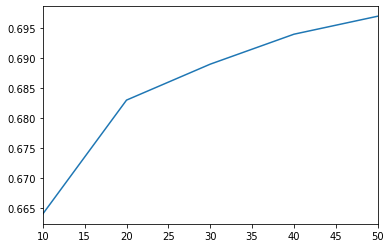

In [64]:
kfold_sel = KFold(n_splits=5, shuffle=True, random_state=241)

indexes = []
scores = []
for num_trees in range(10, 51, 10):
    start_time = datetime.datetime.now()
    #------------------
    clf = GradientBoostingClassifier(n_estimators=num_trees, random_state=241)
    score = cross_val_score(clf, X, y, cv=kfold_sel, scoring='roc_auc', n_jobs=-1).mean()
    #------------------
    print('Number of trees:', num_trees, '\tScore:', score,
          '\tTime elapsed:', datetime.datetime.now() - start_time)
    
    indexes.append(num_trees)
    scores.append(round(score, 3))

pd.Series(scores, index=indexes).plot()

In [65]:
from sklearn.metrics import plot_roc_curve

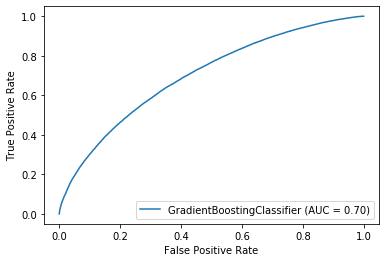

In [66]:
# Plot ROC AUC for a model with 30 trees on training set.
clf = GradientBoostingClassifier(n_estimators=30, random_state=241)
clf.fit(X, y)
plot_roc_curve(clf, X, y)

Training on the set with nearly 100 000 examples (100 columns) using **30 trees** took 35 seconds and gave us roc_auc_score at about 0.69. The scores above show that the greater number of trees the better score.

### 4) Training - Logistic Regression

First we need to scale the data for linear methods like Logistic regression.

In [67]:
from sklearn.preprocessing import StandardScaler

In [68]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [69]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV

In [74]:
clf = LogisticRegression(penalty='l2', random_state=241)
parameters = {'C':[1, 0.3, 0.1, 0.03, 0.01, 0.001]}

start_time = datetime.datetime.now()
#------------------
search = GridSearchCV(clf, param_grid=parameters, cv=kfold_sel, scoring='roc_auc', n_jobs=-1)
search.fit(X_scaled, y)
#------------------
print('Time elapsed (6 models):', datetime.datetime.now() - start_time)

search.best_score_, search.best_params_

Time elapsed (6 models): 0:00:13.020417


(0.7162598557965987, {'C': 0.01})

The linear method is faster than ensemble of trees.

We got slightly better score than Gradient Boosting as we have many features. It can be explained by replacing missing values with 0 which is better for Logistic Regression.

### 5) Logistic Regression without categorical features (heroes)

In [75]:
X_nocat = X.drop(list(X.filter(like='hero')), axis='columns')
X_nocat.drop('lobby_type', axis='columns', inplace=True)
X_nocat.shape

(97230, 90)

In [76]:
X_scaled_nocat = scaler.fit_transform(X_nocat)

clf = LogisticRegression(penalty='l2', random_state=241)
parameters = {'C':[1, 0.3, 0.1, 0.03, 0.01, 0.001]}

start_time = datetime.datetime.now()
#------------------
search = GridSearchCV(clf, param_grid=parameters, cv=kfold_sel, scoring='roc_auc', n_jobs=-1)
search.fit(X_scaled_nocat, y)
#------------------
print('Time elapsed (6 models):', datetime.datetime.now() - start_time)

search.best_score_, search.best_params_

Time elapsed (6 models): 0:00:10.581690


(0.7163215664424338, {'C': 0.01})

The score has improved a bit. So, categorical features **should be encoded properly** rather than presented as numbers we can compare.

### 6) Bring heroes back!
Let's encode hero's categories into TFIDF (frequency–inverse document frequency).

In [77]:
unique_heroes = X['r1_hero'].nunique()
print('Unique IDs of heroes:', unique_heroes)
heroes_id_lst = sorted(X['r1_hero'].unique())

X['r1_hero'].value_counts()

Unique IDs of heroes: 108


11     5045
7      3899
72     3551
39     3341
112    3119
       ... 
66      108
80       88
103      75
58       69
109      20
Name: r1_hero, Length: 108, dtype: int64

We will form a `unique_heroes` number of features such that `i`-th feature will be equal to:
- 0 if the i-th hero did not participate in the match;
- 1 if the i-th hero played for the Radiant team;
- -1 if the i-th hero played for the Dire team.

In [78]:
X_pick = np.zeros((X.shape[0], unique_heroes))

for i, match_id in enumerate(X.index):
    for num in range(5):
        X_pick[i, heroes_id_lst.index(X.loc[match_id, f'r{num+1}_hero'])] = 1
        X_pick[i, heroes_id_lst.index(X.loc[match_id, f'd{num+1}_hero'])] = -1

Let's check the correctness of our manipulations:

In [79]:
X.filter(like='hero').head(3)

,r1_hero,r2_hero,r3_hero,r4_hero,r5_hero,d1_hero,d2_hero,d3_hero,d4_hero,d5_hero
match_id,,,,,,,,,,
0,11,67,29,20,105,4,42,21,37,84
1,42,49,67,37,26,39,88,79,7,12
2,33,98,20,27,4,22,66,86,29,80


In [80]:
pd.DataFrame(X_pick[:3, :7], columns=[f'hero_i{i+1}' for i in range(7)])

,hero_i1,hero_i2,hero_i3,hero_i4,hero_i5,hero_i6,hero_i7
0,0.0,0.0,0.0,-1.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,-1.0
2,0.0,0.0,0.0,1.0,0.0,0.0,0.0


In [81]:
print(X_scaled_nocat.shape, X_pick.shape)
X_scaled_hero_encoded = np.concatenate((X_scaled_nocat, scaler.fit_transform(X_pick)), axis=1)
X_scaled_hero_encoded.shape

(97230, 90) (97230, 108)


(97230, 198)

In [82]:
clf = LogisticRegression(penalty='l2', random_state=241)
parameters = {'C':[1, 0.3, 0.1, 0.03, 0.01, 0.001]}

start_time = datetime.datetime.now()
#------------------
search = GridSearchCV(clf, param_grid=parameters, cv=kfold_sel, scoring='roc_auc', n_jobs=-1)
search.fit(X_scaled_hero_encoded, y)
#------------------
print('Time elapsed (6 models):', datetime.datetime.now() - start_time)

search.best_score_, search.best_params_

Time elapsed (6 models): 0:00:22.010600


(0.7518281840948673, {'C': 0.01})

The score has **improved a lot** comparing previous attempts. Adding of categorical features which are properly encoded helped to increase roc_auc score.

### 7) Add new features

We replace columns with new computed ones.

In [83]:
# X_nocat - is X without columns like='hero' and 'lobby_type'.
X_new = X_nocat.drop(list(X.filter(like='_level')), axis='columns')

X_new.drop(list(X.filter(like='_xp')), axis='columns', inplace=True)
X_new.drop(list(X.filter(like='gold')), axis='columns', inplace=True)
X_new.drop(list(X.filter(like='_lh')), axis='columns', inplace=True)
X_new.drop(list(X.filter(like='_kills')), axis='columns', inplace=True)

print(X_new.shape)
X_new.head(3)

(97230, 40)


,r1_deaths,r1_items,r2_deaths,r2_items,r3_deaths,r3_items,r4_deaths,r4_items,r5_deaths,r5_items,...,radiant_ward_sentry_count,radiant_first_ward_time,dire_bottle_time,dire_courier_time,dire_flying_courier_time,dire_tpscroll_count,dire_boots_count,dire_ward_observer_count,dire_ward_sentry_count,dire_first_ward_time
match_id,,,,,,,,,,,,,,,,,,,,,
0,0,7,0,4,0,8,0,7,1,11,...,0,35.0,103.0,-84.0,221.0,3,4,2,2,-52.0
1,1,12,1,7,0,7,0,7,0,5,...,0,-20.0,149.0,-84.0,195.0,5,4,3,1,-5.0
2,0,12,0,6,0,6,1,6,0,9,...,1,-39.0,45.0,-77.0,221.0,3,4,3,1,13.0


We will compute mean level and experience for each team, and also a sum of gold, killed units, killed players for each team.

In [84]:
levels = X.filter(like='_level')
levels.head(3)

,r1_level,r2_level,r3_level,r4_level,r5_level,d1_level,d2_level,d3_level,d4_level,d5_level
match_id,,,,,,,,,,
0,5,3,5,3,3,3,4,5,3,3
1,4,4,4,3,2,5,3,3,2,4
2,4,3,3,5,3,5,3,3,4,3


In [85]:
X_new['level_r_mean'] = levels.iloc[:, :5].mean(axis=1)
X_new['level_d_mean'] = levels.iloc[:, 5:].mean(axis=1)

exp = X.filter(like='_xp')
X_new['xp_r_mean'] = exp.iloc[:, :5].mean(axis=1)
X_new['xp_d_mean'] = exp.iloc[:, 5:].mean(axis=1)

In [86]:
gold = X.filter(like='gold')
X_new['r_gold'] = gold.iloc[:, :5].sum(axis=1)
X_new['d_gold'] = gold.iloc[:, 5:].sum(axis=1)

killed_units = X.filter(like='_lh')
X_new['r_killed_units'] = killed_units.iloc[:, :5].sum(axis=1)
X_new['d_killed_units'] = killed_units.iloc[:, 5:].sum(axis=1)

killed_players = X.filter(like='_kills')
X_new['r_killed_players'] = killed_players.iloc[:, :5].sum(axis=1)
X_new['d_killed_players'] = killed_players.iloc[:, 5:].sum(axis=1)
X_new.iloc[:, -10:].head(3)

,level_r_mean,level_d_mean,xp_r_mean,xp_d_mean,r_gold,d_gold,r_killed_units,d_killed_units,r_killed_players,d_killed_players
match_id,,,,,,,,,,
0,3.8,3.6,1267.6,1179.0,5022,5021,50,52,0,1
1,3.4,3.4,1074.8,1046.0,4698,5505,45,43,1,2
2,3.6,3.6,1537.0,1350.6,6677,5786,81,70,2,1


In [87]:
print(X_pick.shape, X_new.shape)
X_train_final = np.concatenate((X_pick, X_new), axis=1)
X_train_final.shape

(97230, 108) (97230, 50)


(97230, 158)

### 8) Train models

**Logistic Regression:**

In [88]:
%%time
clf = LogisticRegression(penalty='l2', random_state=241)
parameters = {'C': [1, 0.1, 0.01, 0.001]}

search = GridSearchCV(clf, param_grid=parameters, cv=kfold_sel, scoring='roc_auc', n_jobs=-1)
search.fit(scaler.fit_transform(X_train_final), y)

print(search.best_score_, search.best_params_)

0.7520463495171896 {'C': 0.01}
Wall time: 10.7 s


**Gradient Boosting:**

In [89]:
%%time
clf = GradientBoostingClassifier(n_estimators=50, random_state=241)

print(cross_val_score(clf, X_train_final, y, cv=kfold_sel,
                      scoring='roc_auc', n_jobs=-1).mean())

0.7255598756371684
Wall time: 1min 25s


### 9) Predict winner on test data

In [139]:
best_clf = search.best_estimator_

In [146]:
features_test = pd.read_csv('./features_test.csv', index_col=0)
print(features_test.shape)
features_test.head()

(17177, 102)


,start_time,lobby_type,r1_hero,r1_level,r1_xp,r1_gold,r1_lh,r1_kills,r1_deaths,r1_items,...,radiant_ward_sentry_count,radiant_first_ward_time,dire_bottle_time,dire_courier_time,dire_flying_courier_time,dire_tpscroll_count,dire_boots_count,dire_ward_observer_count,dire_ward_sentry_count,dire_first_ward_time
match_id,,,,,,,,,,,,,,,,,,,,,
6,1430287923,0,93,4,1103,1089,8,0,1,9,...,0,12.0,247.0,-86.0,272.0,3,4,2,0,118.0
7,1430293357,1,20,2,556,570,1,0,0,9,...,2,-29.0,168.0,-54.0,NaN,3,2,2,1,16.0
10,1430301774,1,112,2,751,808,1,0,0,13,...,1,-22.0,46.0,-87.0,186.0,1,3,3,0,-34.0
13,1430323933,1,27,3,708,903,1,1,1,11,...,2,-49.0,30.0,-89.0,210.0,3,4,2,1,-26.0
16,1430331112,1,39,4,1259,661,4,0,0,9,...,0,36.0,180.0,-86.0,180.0,1,3,2,1,-33.0


In [147]:
features_test.fillna(0, inplace=True)

X_test_nocat = features_test.drop(list(features_test.filter(like='hero')), axis='columns')
X_test_nocat.drop(['lobby_type', 'start_time'], axis='columns', inplace=True)

X_test_new = X_test_nocat.drop(list(features_test.filter(like='_level')), axis='columns')

X_test_new.drop(list(features_test.filter(like='_xp')), axis='columns', inplace=True)
X_test_new.drop(list(features_test.filter(like='gold')), axis='columns', inplace=True)
X_test_new.drop(list(features_test.filter(like='_lh')), axis='columns', inplace=True)
X_test_new.drop(list(features_test.filter(like='_kills')), axis='columns', inplace=True)

print(X_test_new.shape)
X_test_new.head(3)

(17177, 40)


,r1_deaths,r1_items,r2_deaths,r2_items,r3_deaths,r3_items,r4_deaths,r4_items,r5_deaths,r5_items,...,radiant_ward_sentry_count,radiant_first_ward_time,dire_bottle_time,dire_courier_time,dire_flying_courier_time,dire_tpscroll_count,dire_boots_count,dire_ward_observer_count,dire_ward_sentry_count,dire_first_ward_time
match_id,,,,,,,,,,,,,,,,,,,,,
6,1,9,2,9,0,6,0,6,0,9,...,0,12.0,247.0,-86.0,272.0,3,4,2,0,118.0
7,0,9,0,7,1,8,0,8,0,6,...,2,-29.0,168.0,-54.0,0.0,3,2,2,1,16.0
10,0,13,0,6,2,6,0,8,0,4,...,1,-22.0,46.0,-87.0,186.0,1,3,3,0,-34.0


In [148]:
levels = features_test.filter(like='_level')
X_test_new['level_r_mean'] = levels.iloc[:, :5].mean(axis=1)
X_test_new['level_d_mean'] = levels.iloc[:, 5:].mean(axis=1)

exp = features_test.filter(like='_xp')
X_test_new['xp_r_mean'] = exp.iloc[:, :5].mean(axis=1)
X_test_new['xp_d_mean'] = exp.iloc[:, 5:].mean(axis=1)

gold = features_test.filter(like='gold')
X_test_new['r_gold'] = gold.iloc[:, :5].sum(axis=1)
X_test_new['d_gold'] = gold.iloc[:, 5:].sum(axis=1)

killed_units = features_test.filter(like='_lh')
X_test_new['r_killed_units'] = killed_units.iloc[:, :5].sum(axis=1)
X_test_new['d_killed_units'] = killed_units.iloc[:, 5:].sum(axis=1)

killed_players = features_test.filter(like='_kills')
X_test_new['r_killed_players'] = killed_players.iloc[:, :5].sum(axis=1)
X_test_new['d_killed_players'] = killed_players.iloc[:, 5:].sum(axis=1)
X_test_new.iloc[:, -10:].head(3)

,level_r_mean,level_d_mean,xp_r_mean,xp_d_mean,r_gold,d_gold,r_killed_units,d_killed_units,r_killed_players,d_killed_players
match_id,,,,,,,,,,
6,3.6,3.6,1367.2,1315.0,6034,5796,54,50,2,3
7,3.4,3.6,1230.4,1228.4,5544,5000,59,49,1,1
10,3.2,3.4,1118.0,1194.4,5377,6412,56,63,1,2


In [149]:
X_test_pick = np.zeros((X_test_new.shape[0], unique_heroes))
for i, match_id in enumerate(features_test.index):
    for num in range(5):
        X_test_pick[i, heroes_id_lst.index(features_test.loc[match_id, f'r{num+1}_hero'])] = 1
        X_test_pick[i, heroes_id_lst.index(features_test.loc[match_id, f'd{num+1}_hero'])] = -1

print(X_test_new.shape, X_test_pick.shape)
X_test = np.concatenate((X_test_new, X_test_pick), axis=1)
X_test.shape

(17177, 50) (17177, 108)


(17177, 158)

In [150]:
X_scaled_test = scaler.fit_transform(X_test)
X_scaled_test.shape

(17177, 158)

[0.64595319 0.91069639 0.74283516 0.83640345 0.57624839 0.5587136
 0.5686057  0.66161376 0.67213383 0.38161404]


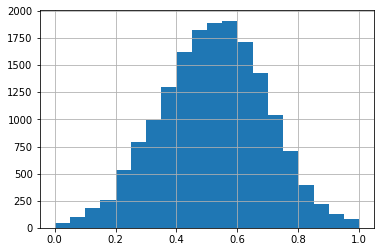

In [151]:
y_pred = best_clf.predict_proba(X_scaled_test)[:, 1]
print(y_pred[:10])
pd.Series(y_pred).hist(bins=20)

In [152]:
y_pred.min(), y_pred.max()

(0.00023138353884684886, 0.9999702083195379)